# Tuillaut Method Implementation

The following notebook has been devised to fully reproduce the method presented in Tulliaut's paper "Thèorie des phénomènes des Satellitres Galiléens de Jupiter".

The first section fo the notebook is dedicated to the Implementation of a classical method, as described by Peters in "Eclipses Of Natural Planetary Sattelites" but with Tulliat's matrix-wise implementation.

The second section of the Notebook is dedicated to the computation of ephemeridis for the jovian system with chebyshev Polynomials, as described by Tulliat himself in the paper already quoted above.

In [1]:
import sys
sys.path.insert(1, '../Calendar/')

from PhenomenaDetection import Detection, Phenomenom, Result
from Calculation import Calculation

from pymeeus.Epoch import Epoch
from pymeeus.Earth import Earth
from pymeeus.Jupiter import Jupiter
from pymeeus.JupiterMoons import JupiterMoons
from pymeeus.Sun import Sun

import numpy as np
import matplotlib.pyplot as plt

from numpy import cos as cos
from numpy import sin as sin
from numpy import tan as tan
from numpy import arccos as arccos
from numpy import arcsin as arcsin
from numpy import arctan2 as arctan2

s_jd = 1.157401129603386e-05

In [2]:
#define the radii of Jupiter's moons, as assumed by Tulliat
moons_radii = np.array([1821/71492, 1565/71492, 2634/71492, 2403/71492])

An error was found in aterm of the E5-Implementation and was corrected, check wether the computaion still works after the last correction

In [3]:
epoch = Epoch()
epoch.set(1992, 12, 16, 0, 0, 59)
time_step = 1.157401129603386e-05 * 60

In [4]:
position_matrix = (np.array(JupiterMoons.rectangular_positions(epoch))).reshape(4, 3)
print(position_matrix)

[[ -3.450205     0.21370135  -4.81894081]
 [  7.44184724   0.27524608  -5.7471321 ]
 [  1.20108379   0.58999039 -14.94058358]
 [  7.07200221   1.02896812 -25.22442592]]


Accuracy thowards Meeus values incresed, the discrepancy encountered in the position of Ganymede appears to be the result of working with too few significant digits since it is completely reproducible when successively approximating the value

In [5]:
epoch = Epoch()
epoch.set(2020, 1, 2, 12, 0, 59)
#one minute time-step
time_step = 1.157401129603386e-5 *60

In [6]:
epsilon = 1/15.4  #flatness ratio of jupiter on the equator, according to Tuillaut
r_jupiter = 71492 #Jupiter radius in km accoring to Tulliatu

au_j_r = 149597870700/r_jupiter # astronomical-unit expressed in jupiter radii

#Flatness according to Tulliaut
rho = (1-epsilon)**(-2)
print("Flatness ratio at the equator (radius) : " + str(rho))

Flatness ratio at the equator (radius) : 1.1437114197530864


ALL FOLLOWING COMPUTATIONS USING AU

In [7]:
M = np.array([[1,0,0],[0,1,0],[0,0,rho]])
print("Compression matrix : ")
print(M)

Compression matrix : 
[[1.         0.         0.        ]
 [0.         1.         0.        ]
 [0.         0.         1.14371142]]


In [8]:
#point on the surface of jupiter, taking jupiter's north pole as an example
X = np.array([[0],[0],[1]])/ au_j_r

#Heliocentric position of Jupiter, ecliptical spherical coorinates system
l, b, r = Jupiter.geometric_heliocentric_position(epoch)

#convert from spherical to cartesian coordinates, always in the ecliptical system
x = r * cos(b.rad()) * cos(l.rad()) 
y = r * cos(b.rad()) * sin(l.rad()) 
z = r * sin(b.rad())

#place in column-vector
X_jupiter = (np.array([x, y, z])).T    
X_jupiter = X_jupiter.reshape(3,1)

print("Jupiter's rectangualr ecliptical position in AU")
print(X_jupiter)

#add the point on jupiter's surface --> description of a sphere translated to jupiter's position, Jupiter is placed
#on the origin of the coordinates system for the following computations
print("Jupiter's position in jupiter radii with point on sphere")
print(X)

#computation according to Meeus
a_squared = X.T @ M @ X
print("a_squared term")
print(a_squared)

Jupiter's rectangualr ecliptical position in AU
[[ 0.56264479]
 [-5.19665321]
 [ 0.00934016]]
Jupiter's position in jupiter radii with point on sphere
[[0.00000000e+00]
 [0.00000000e+00]
 [4.77894503e-07]]
a_squared term
[[2.61204423e-13]]


In [9]:
#Satellitenkoordinaten von der Sonne aus
position_matrix = (np.array(JupiterMoons.rectangular_positions(epoch, solar = True))).reshape(4, 3)
#extract only one line-vector for a single satellite, Io will be taken as an example for the following computations

Q = position_matrix[0, :].T

print("Position of IO in Jupiter Radii")
print(Q)

Q_buffer = np.zeros([3,1])

Q_buffer = Q;

#It is necessare to rotate the coordinate-system to be working with Tulliauts method

Q = np.array([-Q_buffer[2],Q_buffer[0] ,Q_buffer[1]])

Q = Q/ au_j_r

print("Io's position in AU, Tulliauts coordinates System")
print(Q)

Position of IO in Jupiter Radii
[ 1.40368486 -0.21109582  5.75218358]
Io's position in AU, Tulliauts coordinates System
[-2.74893691e-06  6.70813276e-07 -1.00881530e-07]


In [10]:
#Position of the Sun in the given coordinates system is simply the distance to the Sun on the positive x-axis

S = np.array([[np.linalg.norm(X_jupiter)],[0],[0]])

print(S)

[[5.22703176]
 [0.        ]
 [0.        ]]


In [11]:
#verify plausibility, for the given epoch Delta_s should have a negativevalue since the 
Delta_s = (S.T@M@Q - a_squared)**2 - (S.T@M@S - a_squared)*(Q.T@M@Q - a_squared)

print(Delta_s)

[[-5.4759949e-12]]


In [12]:
#check weather the Method is working in a timespan of 3600 minutes --> 60h
n = 3600

x_vec = np.zeros([n,1])
y_vec = np.zeros([n,1])
z_vec = np.zeros([n,1])
delta_s_val = np.zeros([n,1])
t = np.zeros([n,1])

epoch = Epoch()
epoch.set(2020, 1, 2, 12, 0, 59)

X = np.array([[0],[0],[1]])/ au_j_r
M = np.array([[1,0,0],[0,1,0],[0,0,rho]])

Q_buffer = np.zeros([3,1])
    
for i in range(0, n):

    epoch += time_step
    
    a_squared = X.T @ M @ X
    
    l, b, r = Jupiter.geometric_heliocentric_position(epoch)

    S = np.array([r, 0, 0]).T
    
    position_matrix = (np.array(JupiterMoons.rectangular_positions(epoch, solar = True))).reshape(4, 3)
    #extract only one line-vector of a single satellite
    #taking Io into consideration, since there should be an eclipse on the given day

    Q = position_matrix[0, :].T

    Q_buffer = Q
    
    Q = np.array([-Q_buffer[2],Q_buffer[0] ,Q_buffer[1]])
    
    Q = Q / au_j_r
    
    x_vec[i] = Q[0]
    y_vec[i] = Q[1]
    z_vec[i] = Q[2]
    
    Delta_s = (S.T@M@Q - a_squared)**2 - (S.T@M@S - a_squared)*(Q.T@M@Q - a_squared)

    delta_s_val[i] = Delta_s
    
    t[i] = i
    
    if(Delta_s  > 0) :
        print(epoch.get_full_date())
        print(Delta_s)

(2020, 1, 2, 12, 26, 58.991540372371674)
[[1.32670975e-13]]
(2020, 1, 2, 12, 27, 58.9912149310112)
[[3.15658281e-13]]
(2020, 1, 2, 12, 28, 58.990889489650726)
[[4.96176615e-13]]
(2020, 1, 2, 12, 29, 58.99056404829025)
[[6.74221638e-13]]
(2020, 1, 2, 12, 30, 58.99023860692978)
[[8.49789068e-13]]
(2020, 1, 2, 12, 31, 58.989913165569305)
[[1.02287468e-12]]
(2020, 1, 2, 12, 32, 58.98958772420883)
[[1.19347432e-12]]
(2020, 1, 2, 12, 33, 58.98926228284836)
[[1.36158389e-12]]
(2020, 1, 2, 12, 34, 58.988936841487885)
[[1.52719933e-12]]
(2020, 1, 2, 12, 35, 58.98861140012741)
[[1.69031666e-12]]
(2020, 1, 2, 12, 36, 58.98828595876694)
[[1.85093197e-12]]
(2020, 1, 2, 12, 37, 58.987960517406464)
[[2.00904139e-12]]
(2020, 1, 2, 12, 38, 58.98763507604599)
[[2.16464112e-12]]
(2020, 1, 2, 12, 39, 58.987309634685516)
[[2.31772742e-12]]
(2020, 1, 2, 12, 40, 58.98698419332504)
[[2.4682966e-12]]
(2020, 1, 2, 12, 41, 58.98665875196457)
[[2.61634504e-12]]
(2020, 1, 2, 12, 42, 58.986333310604095)
[[2.7618691

(2020, 1, 3, 9, 35, 58.57855528593063)
[[5.98903012e-14]]
(2020, 1, 3, 9, 36, 58.57822984457016)
[[2.4498075e-13]]
(2020, 1, 3, 9, 37, 58.577904403209686)
[[4.2757504e-13]]
(2020, 1, 3, 9, 38, 58.57757896184921)
[[6.07668686e-13]]
(2020, 1, 3, 9, 39, 58.57725352048874)
[[7.85257262e-13]]
(2020, 1, 3, 9, 40, 58.576928079128265)
[[9.60336406e-13]]
(2020, 1, 3, 9, 41, 58.57660263776779)
[[1.13290182e-12]]
(2020, 1, 3, 9, 42, 58.57627719640732)
[[1.30294925e-12]]
(2020, 1, 3, 9, 43, 58.575951755046844)
[[1.47047453e-12]]
(2020, 1, 3, 9, 44, 58.57562631368637)
[[1.63547355e-12]]
(2020, 1, 3, 9, 45, 58.5753008723259)
[[1.79794225e-12]]
(2020, 1, 3, 9, 46, 58.574975430965424)
[[1.95787663e-12]]
(2020, 1, 3, 9, 47, 58.57464998960495)
[[2.11527278e-12]]
(2020, 1, 3, 9, 48, 58.574324548244476)
[[2.27012682e-12]]
(2020, 1, 3, 9, 49, 58.573999106884)
[[2.42243494e-12]]
(2020, 1, 3, 9, 50, 58.57367366552353)
[[2.57219342e-12]]
(2020, 1, 3, 9, 51, 58.573348224163055)
[[2.71939857e-12]]
(2020, 1, 3, 

(2020, 1, 4, 6, 54, 58.16231578588486)
[[6.69111437e-15]]
(2020, 1, 4, 6, 55, 58.16199034452438)
[[1.91357478e-13]]
(2020, 1, 4, 6, 56, 58.16166490316391)
[[3.73557978e-13]]
(2020, 1, 4, 6, 57, 58.161339461803436)
[[5.5328823e-13]]
(2020, 1, 4, 6, 58, 58.16101402044296)
[[7.30543912e-13]]
(2020, 1, 4, 6, 59, 58.16068857908249)
[[9.05320763e-13]]
(2020, 1, 4, 7, 0, 58.160363137722015)
[[1.07761458e-12]]
(2020, 1, 4, 7, 1, 58.16003769636154)
[[1.24742121e-12]]
(2020, 1, 4, 7, 2, 58.15971225500107)
[[1.41473658e-12]]
(2020, 1, 4, 7, 3, 58.159386813640594)
[[1.57955666e-12]]
(2020, 1, 4, 7, 4, 58.15906137228012)
[[1.74187748e-12]]
(2020, 1, 4, 7, 5, 58.15873593091965)
[[1.90169515e-12]]
(2020, 1, 4, 7, 6, 58.158410489559174)
[[2.05900581e-12]]
(2020, 1, 4, 7, 7, 58.1580850481987)
[[2.21380568e-12]]
(2020, 1, 4, 7, 8, 58.157759606838226)
[[2.36609104e-12]]
(2020, 1, 4, 7, 9, 58.15743416547775)
[[2.51585823e-12]]
(2020, 1, 4, 7, 10, 58.15710872411728)
[[2.66310364e-12]]
(2020, 1, 4, 7, 11, 5

A couple of plots to verify weather everything went correctly and for conducting a visual plausibility check

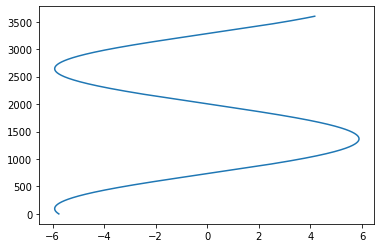

In [13]:
plt.plot(x_vec*au_j_r, t)

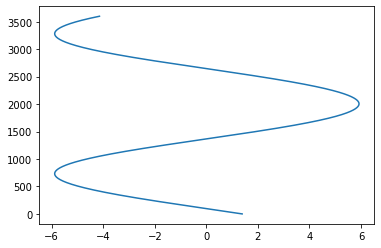

In [14]:
plt.plot(y_vec*au_j_r, t)

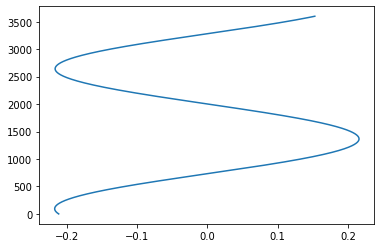

In [15]:
plt.plot(z_vec*au_j_r, t)

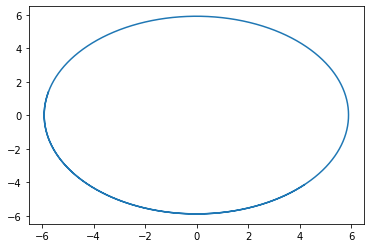

In [16]:
plt.plot(x_vec*au_j_r, y_vec*au_j_r)

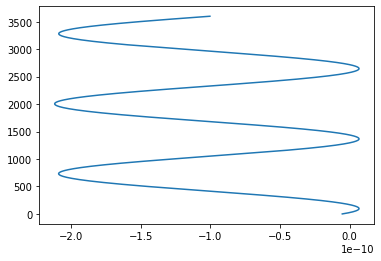

In [17]:
plt.plot(delta_s_val, t)

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


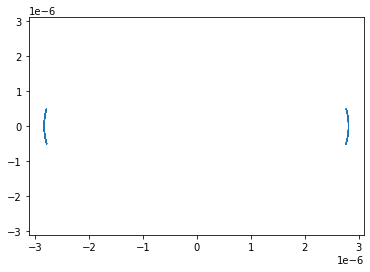

In [18]:
plt.scatter(x_vec, y_vec, delta_s_val*10**-6)

The last two plots appear to be plausible, the two areas in which the Delta_s value becomes positive should be exactely as stated above

Now let's implement the same method with the Earth as the tipof the perspective cone

In [19]:
epoch.set(2020, 1, 2, 12, 0, 59)

In [20]:
#Position of the Earth, heliocentric ecliptical spherical coordinates system

l_e, b_e, r_e = Earth.geometric_heliocentric_position(epoch)

x_e = r * cos(b_e.rad()) * cos(l_e.rad()) 
y_e = r * cos(b_e.rad()) * sin(l_e.rad()) 
z_e = r * sin(b_e.rad())

#Heliocentric position of Jupiter, ecliptical spherical coorinates system
l_j, b_j, r_j = Jupiter.geometric_heliocentric_position(epoch)

#convert from spherical to cartesian coordinates, always in the ecliptical system
x_j = r_j * cos(b_j.rad()) * cos(l_j.rad()) 
y_j = r_j * cos(b_j.rad()) * sin(l_j.rad()) 
z_j = r_j * sin(b_j.rad())

Delta = np.array([x_j - x_e, y_j - y_e, z_j - z_e])

In [21]:
T = np.array([np.linalg.norm(Delta), 0, 0]).T
print("Earth-Jupiter distance in AU")
print(T)

Earth-Jupiter distance in AU
[10.44167453  0.          0.        ]


In [22]:
a_squared = X.T @ M @ X

In [23]:
#Satellitenkoordinaten von der Sonne aus
position_matrix = (np.array(JupiterMoons.rectangular_positions(epoch, solar = False))).reshape(4, 3)
#extract only one line-vector for a single satellite, Io will be taken as an example for the following computations

Q = position_matrix[0, :].T

print("Position of IO in Jupiter Radii")
print(Q)

Q_buffer = np.zeros([3,1])

Q_buffer = Q;

#It is necessare to rotate the coordinate-system to be working with Tulliauts method

Q = np.array([-Q_buffer[2],Q_buffer[0] ,Q_buffer[1]])

Q = Q/ au_j_r

print("Io's position in AU, Tulliauts coordinates System")
print(Q)

Position of IO in Jupiter Radii
[ 1.60315767 -0.20606299  5.70029999]
Io's position in AU, Tulliauts coordinates System
[-2.72414203e-06  7.66140239e-07 -9.84763700e-08]


In [24]:
Delta_t = (T.T@M@Q-a_squared)**2 - (T.T@M@T - a_squared)*(Q.T@M@Q-a_squared)

print(Delta_t)

[[-3.67270966e-11]]


In [25]:
#check weather the Method is working in a timespan of 3600 minutes --> 60h
n = 3600

x_vec = np.zeros([n,1])
y_vec = np.zeros([n,1])
z_vec = np.zeros([n,1])
delta_t_val = np.zeros([n,1])
t = np.zeros([n,1])

epoch = Epoch()
epoch.set(2020, 1, 2, 12, 0, 59)

X = np.array([[0],[0],[1]])/ au_j_r
M = np.array([[1,0,0],[0,1,0],[0,0,rho]])

Q_buffer = np.zeros([3,1])
    
for i in range(0, n):

    epoch += time_step
    
    a_squared = X.T @ M @ X
    
    #Position of the Earth, heliocentric ecliptical spherical coordinates system

    l_e, b_e, r_e = Earth.geometric_heliocentric_position(epoch)

    x_e = r * cos(b_e.rad()) * cos(l_e.rad()) 
    y_e = r * cos(b_e.rad()) * sin(l_e.rad()) 
    z_e = r * sin(b_e.rad())

    #Heliocentric position of Jupiter, ecliptical spherical coorinates system
    l_j, b_j, r_j = Jupiter.geometric_heliocentric_position(epoch)

    #convert from spherical to cartesian coordinates, always in the ecliptical system
    x_j = r_j * cos(b_j.rad()) * cos(l_j.rad()) 
    y_j = r_j * cos(b_j.rad()) * sin(l_j.rad()) 
    z_j = r_j * sin(b_j.rad())

    Delta = np.array([x_e - x_j, y_e - y_j, z_e - z_j])

    T = np.array([np.linalg.norm(Delta), 0, 0]).T
    
    position_matrix = (np.array(JupiterMoons.rectangular_positions(epoch, solar = False))).reshape(4, 3)
    #extract only one line-vector of a single satellite
    #taking Io into consideration, since there should be an eclipse on the given day

    Q = position_matrix[0, :].T

    Q_buffer = Q
    
    Q = np.array([-Q_buffer[2],Q_buffer[0] ,Q_buffer[1]])
    
    Q = Q / au_j_r
    
    x_vec[i] = Q[0]
    y_vec[i] = Q[1]
    z_vec[i] = Q[2]
    
    Delta_t = (T.T@M@Q-a_squared)**2 - (T.T@M@T - a_squared)*(Q.T@M@Q-a_squared)

    delta_t_val[i] = Delta_t
    
    t[i] = i
    
    if(Delta_t  > 0) :
        print(epoch.get_full_date())
        print(Delta_t)

(2020, 1, 2, 12, 40, 58.98698419332504)
[[3.96443188e-13]]
(2020, 1, 2, 12, 41, 58.98665875196457)
[[1.12855115e-12]]
(2020, 1, 2, 12, 42, 58.986333310604095)
[[1.85082148e-12]]
(2020, 1, 2, 12, 43, 58.98600786924362)
[[2.56323683e-12]]
(2020, 1, 2, 12, 44, 58.98568242788315)
[[3.2657801e-12]]
(2020, 1, 2, 12, 45, 58.985356986522675)
[[3.95843444e-12]]
(2020, 1, 2, 12, 46, 58.9850315451622)
[[4.64118322e-12]]
(2020, 1, 2, 12, 47, 58.98470610380173)
[[5.31401005e-12]]
(2020, 1, 2, 12, 48, 58.984380662441254)
[[5.97689879e-12]]
(2020, 1, 2, 12, 49, 58.98405522108078)
[[6.62983353e-12]]
(2020, 1, 2, 12, 50, 58.983729779720306)
[[7.27279859e-12]]
(2020, 1, 2, 12, 51, 58.98340433835983)
[[7.90577855e-12]]
(2020, 1, 2, 12, 52, 58.98307889699936)
[[8.52875821e-12]]
(2020, 1, 2, 12, 53, 58.982753455638885)
[[9.14172261e-12]]
(2020, 1, 2, 12, 54, 58.98242801427841)
[[9.74465706e-12]]
(2020, 1, 2, 12, 55, 58.98210257291794)
[[1.03375471e-11]]
(2020, 1, 2, 12, 56, 58.981777131557465)
[[1.09203784

(2020, 1, 3, 9, 50, 58.57367366552353)
[[2.33412555e-13]]
(2020, 1, 3, 9, 51, 58.573348224163055)
[[9.71552666e-13]]
(2020, 1, 3, 9, 52, 58.57302278280258)
[[1.69975548e-12]]
(2020, 1, 3, 9, 53, 58.57269734144211)
[[2.41800317e-12]]
(2020, 1, 3, 9, 54, 58.572371900081635)
[[3.12627812e-12]]
(2020, 1, 3, 9, 55, 58.57204645872116)
[[3.82456299e-12]]
(2020, 1, 3, 9, 56, 58.57172101736069)
[[4.51284067e-12]]
(2020, 1, 3, 9, 57, 58.571395576000214)
[[5.1910943e-12]]
(2020, 1, 3, 9, 58, 58.57107013463974)
[[5.85930725e-12]]
(2020, 1, 3, 9, 59, 58.570744693279266)
[[6.51746318e-12]]
(2020, 1, 3, 10, 0, 58.57041925191879)
[[7.16554594e-12]]
(2020, 1, 3, 10, 1, 58.57009381055832)
[[7.80353967e-12]]
(2020, 1, 3, 10, 2, 58.569768369197845)
[[8.43142874e-12]]
(2020, 1, 3, 10, 3, 58.56944292783737)
[[9.04919777e-12]]
(2020, 1, 3, 10, 4, 58.5691174864769)
[[9.65683164e-12]]
(2020, 1, 3, 10, 5, 58.568792045116425)
[[1.02543155e-11]]
(2020, 1, 3, 10, 6, 58.56846660375595)
[[1.08416346e-11]]
(2020, 1, 

(2020, 1, 4, 7, 10, 58.15710872411728)
[[1.47964475e-14]]
(2020, 1, 4, 7, 11, 58.156783282756805)
[[7.50998036e-13]]
(2020, 1, 4, 7, 12, 58.15645784139633)
[[1.47738519e-12]]
(2020, 1, 4, 7, 13, 58.15613240003586)
[[2.19394047e-12]]
(2020, 1, 4, 7, 14, 58.155806958675385)
[[2.90064668e-12]]
(2020, 1, 4, 7, 15, 58.15548151731491)
[[3.59748686e-12]]
(2020, 1, 4, 7, 16, 58.15515607595444)
[[4.28444429e-12]]
(2020, 1, 4, 7, 17, 58.154830634593964)
[[4.96150247e-12]]
(2020, 1, 4, 7, 18, 58.15450519323349)
[[5.62864517e-12]]
(2020, 1, 4, 7, 19, 58.154179751873016)
[[6.28585636e-12]]
(2020, 1, 4, 7, 20, 58.15385431051254)
[[6.93312027e-12]]
(2020, 1, 4, 7, 21, 58.15352886915207)
[[7.57042137e-12]]
(2020, 1, 4, 7, 22, 58.153203427791595)
[[8.19774435e-12]]
(2020, 1, 4, 7, 23, 58.15287798643112)
[[8.81507418e-12]]
(2020, 1, 4, 7, 24, 58.15255254507065)
[[9.42239602e-12]]
(2020, 1, 4, 7, 25, 58.152227103710175)
[[1.00196953e-11]]
(2020, 1, 4, 7, 26, 58.1519016623497)
[[1.06069577e-11]]
(2020, 1,

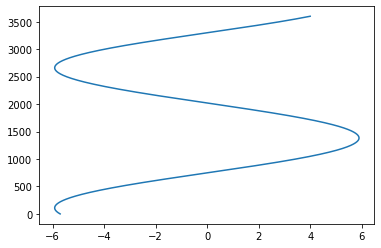

In [26]:
plt.plot(x_vec*au_j_r, t)

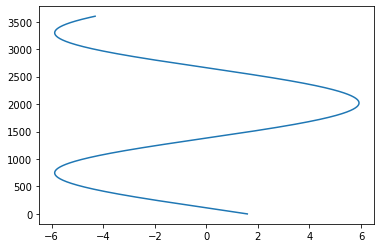

In [27]:
plt.plot(y_vec*au_j_r, t)

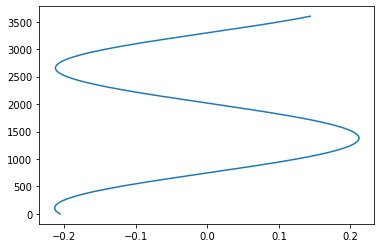

In [28]:
plt.plot(z_vec*au_j_r, t)

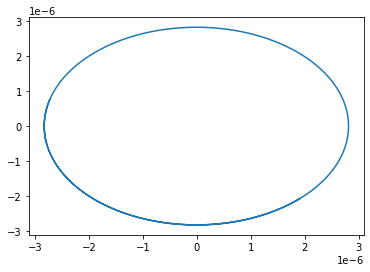

In [29]:
plt.plot(x_vec, y_vec)

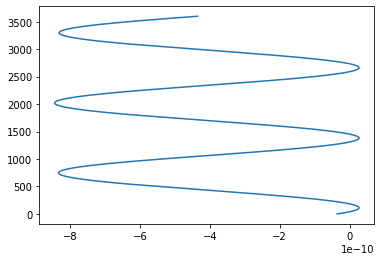

In [30]:
plt.plot(delta_t_val, t)

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


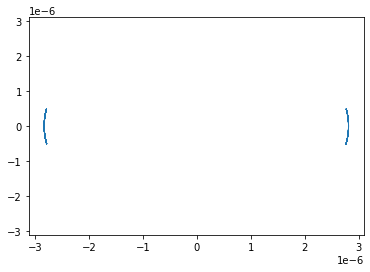

In [31]:
plt.scatter(x_vec, y_vec, delta_t_val*10**-3)

Phase corrected shadow cone, since this time we also have to take the earth's position into account, keep Jupiter as the origin of the coordinates system and orient it thowards the sun as it has been done until now for the computation of Delta_s_comma

In [32]:
epoch = Epoch()
epoch.set(2020, 1, 2, 12, 0, 59)

X = np.array([[0],[0],[1]])/ au_j_r
M = np.array([[1,0,0],[0,1,0],[0,0,rho]])

Q_buffer = np.zeros([3,1])

a_squared = X.T @ M @ X

#Position of the Earth, heliocentric ecliptical spherical coordinates system

l_e, b_e, r_e = Earth.geometric_heliocentric_position(epoch)

x_e = r * cos(b_e.rad()) * cos(l_e.rad()) 
y_e = r * cos(b_e.rad()) * sin(l_e.rad()) 
z_e = r * sin(b_e.rad())

#Heliocentric position of Jupiter, ecliptical spherical coorinates system
l_j, b_j, r_j = Jupiter.geometric_heliocentric_position(epoch)

#convert from spherical to cartesian coordinates, always in the ecliptical system
x_j = r_j * cos(b_j.rad()) * cos(l_j.rad()) 
y_j = r_j * cos(b_j.rad()) * sin(l_j.rad()) 
z_j = r_j * sin(b_j.rad())

T = np.array([x_j - x_e, y_j - y_e, z_j - z_e])

S = np.array([r_j, 0, 0]).T

position_matrix = (np.array(JupiterMoons.rectangular_positions(epoch, solar = True))).reshape(4, 3)
#extract only one line-vector of a single satellite
#taking Io into consideration, since there should be an eclipse on the given day

Q = position_matrix[0, :].T

Q_buffer = Q

Q = np.array([-Q_buffer[2],Q_buffer[0] ,Q_buffer[1]])

Q = Q / au_j_r

Delta_s_comma = (S.T@M@S - a_squared)*(a_squared - T.T@M@Q)**2 + 2*(S.T@M@Q - a_squared)*(a_squared - T.T@M@Q)*(T.T@M@S - a_squared)+(Q.T@M@Q - a_squared)*(T.T@M@S-a_squared)**2

In [33]:
print(Delta_s_comma)

[[1.323215e-09]]


In [34]:
#check weather the Method is working in a timespan of 3600 minutes --> 60h
n = 3600

x_vec = np.zeros([n,1])
y_vec = np.zeros([n,1])
z_vec = np.zeros([n,1])
delta_s_comma_val = np.zeros([n,1])
t = np.zeros([n,1])

epoch = Epoch()
epoch.set(2020, 1, 2, 12, 0, 59)

X = np.array([[0],[0],[1]])/ au_j_r
M = np.array([[1,0,0],[0,1,0],[0,0,rho]])

Q_buffer = np.zeros([3,1])
    
for i in range(0, n):

    epoch += time_step

    a_squared = X.T @ M @ X

    #Position of the Earth, heliocentric ecliptical spherical coordinates system

    l_e, b_e, r_e = Earth.geometric_heliocentric_position(epoch)

    x_e = r_e * cos(b_e.rad()) * cos(l_e.rad()) 
    y_e = r_e * cos(b_e.rad()) * sin(l_e.rad()) 
    z_e = r_e * sin(b_e.rad())

    #Heliocentric position of Jupiter, ecliptical spherical coorinates system
    l_j, b_j, r_j = Jupiter.geometric_heliocentric_position(epoch)

    #convert from spherical to cartesian coordinates, always in the ecliptical system
    x_j = r_j * cos(b_j.rad()) * cos(l_j.rad()) 
    y_j = r_j * cos(b_j.rad()) * sin(l_j.rad()) 
    z_j = r_j * sin(b_j.rad())

    l_diff = l_e - l_j
    b_diff = b_e - b_j
    
    r_diff =np.linalg.norm(np.array([x_e - x_j, y_e - y_j, z_e - z_j]))
    
    x_diff = r_diff * cos(b_diff.rad()) * cos(l_diff.rad()) 
    y_diff = r_diff * cos(b_diff.rad()) * sin(l_diff.rad())
    z_diff = r_diff * sin(b_diff.rad()) 
    
    T = np.array([x_diff, y_diff, z_diff]).T

    S = np.array([r_j, 0, 0]).T

    position_matrix = (np.array(JupiterMoons.rectangular_positions(epoch, solar = True))).reshape(4, 3)
    #extract only one line-vector of a single satellite
    #taking Io into consideration, since there should be an eclipse on the given day

    Q = position_matrix[0, :].T

    Q_buffer = Q

    Q = np.array([-Q_buffer[2],Q_buffer[0] ,Q_buffer[1]])

    Q = Q / au_j_r

    Delta_s_comma = (S.T@M@S - a_squared)*((a_squared - T.T@M@Q)**2) + 2*(S.T@M@Q - a_squared)*(a_squared - T.T@M@Q)*(T.T@M@S - a_squared)+(Q.T@M@Q - a_squared)*((T.T@M@S-a_squared)**2)
    
    x_vec[i] = Q[0]
    y_vec[i] = Q[1]
    z_vec[i] = Q[2]
    
    delta_s_comma_val[i] = Delta_s_comma
    
    t[i] = i
    
    if(Delta_s_comma  < 0) :
        print(epoch.get_full_date())
        print(Delta_s_comma)

(2020, 1, 2, 12, 26, 58.991540372371674)
[[-2.81927895e-12]]
(2020, 1, 2, 12, 27, 58.9912149310112)
[[-9.86760832e-12]]
(2020, 1, 2, 12, 28, 58.990889489650726)
[[-1.68208205e-11]]
(2020, 1, 2, 12, 29, 58.99056404829025)
[[-2.36787486e-11]]
(2020, 1, 2, 12, 30, 58.99023860692978)
[[-3.04412276e-11]]
(2020, 1, 2, 12, 31, 58.989913165569305)
[[-3.71080951e-11]]
(2020, 1, 2, 12, 32, 58.98958772420883)
[[-4.36791907e-11]]
(2020, 1, 2, 12, 33, 58.98926228284836)
[[-5.01543568e-11]]
(2020, 1, 2, 12, 34, 58.988936841487885)
[[-5.65334375e-11]]
(2020, 1, 2, 12, 35, 58.98861140012741)
[[-6.28162796e-11]]
(2020, 1, 2, 12, 36, 58.98828595876694)
[[-6.90027321e-11]]
(2020, 1, 2, 12, 37, 58.987960517406464)
[[-7.50926463e-11]]
(2020, 1, 2, 12, 38, 58.98763507604599)
[[-8.10858758e-11]]
(2020, 1, 2, 12, 39, 58.987309634685516)
[[-8.69822766e-11]]
(2020, 1, 2, 12, 40, 58.98698419332504)
[[-9.2781707e-11]]
(2020, 1, 2, 12, 41, 58.98665875196457)
[[-9.84840275e-11]]
(2020, 1, 2, 12, 42, 58.986333310604

(2020, 1, 3, 9, 36, 58.57822984457016)
[[-6.38259986e-12]]
(2020, 1, 3, 9, 37, 58.577904403209686)
[[-1.34122125e-11]]
(2020, 1, 3, 9, 38, 58.57757896184921)
[[-2.03455347e-11]]
(2020, 1, 3, 9, 39, 58.57725352048874)
[[-2.7182396e-11]]
(2020, 1, 3, 9, 40, 58.576928079128265)
[[-3.39226286e-11]]
(2020, 1, 3, 9, 41, 58.57660263776779)
[[-4.0566067e-11]]
(2020, 1, 3, 9, 42, 58.57627719640732)
[[-4.71125482e-11]]
(2020, 1, 3, 9, 43, 58.575951755046844)
[[-5.35619113e-11]]
(2020, 1, 3, 9, 44, 58.57562631368637)
[[-5.9913998e-11]]
(2020, 1, 3, 9, 45, 58.5753008723259)
[[-6.61686525e-11]]
(2020, 1, 3, 9, 46, 58.574975430965424)
[[-7.23257211e-11]]
(2020, 1, 3, 9, 47, 58.57464998960495)
[[-7.83850527e-11]]
(2020, 1, 3, 9, 48, 58.574324548244476)
[[-8.43464986e-11]]
(2020, 1, 3, 9, 49, 58.573999106884)
[[-9.02099125e-11]]
(2020, 1, 3, 9, 50, 58.57367366552353)
[[-9.59751504e-11]]
(2020, 1, 3, 9, 51, 58.573348224163055)
[[-1.01642071e-10]]
(2020, 1, 3, 9, 52, 58.57302278280258)
[[-1.07210535e-10

(2020, 1, 4, 6, 55, 58.16199034452438)
[[-3.44670677e-12]]
(2020, 1, 4, 6, 56, 58.16166490316391)
[[-1.04571821e-11]]
(2020, 1, 4, 6, 57, 58.161339461803436)
[[-1.73725888e-11]]
(2020, 1, 4, 6, 58, 58.16101402044296)
[[-2.41927608e-11]]
(2020, 1, 4, 6, 59, 58.16068857908249)
[[-3.09175342e-11]]
(2020, 1, 4, 7, 0, 58.160363137722015)
[[-3.75467472e-11]]
(2020, 1, 4, 7, 1, 58.16003769636154)
[[-4.40802407e-11]]
(2020, 1, 4, 7, 2, 58.15971225500107)
[[-5.05178574e-11]]
(2020, 1, 4, 7, 3, 58.159386813640594)
[[-5.68594427e-11]]
(2020, 1, 4, 7, 4, 58.15906137228012)
[[-6.31048442e-11]]
(2020, 1, 4, 7, 5, 58.15873593091965)
[[-6.92539116e-11]]
(2020, 1, 4, 7, 6, 58.158410489559174)
[[-7.53064973e-11]]
(2020, 1, 4, 7, 7, 58.1580850481987)
[[-8.12624558e-11]]
(2020, 1, 4, 7, 8, 58.157759606838226)
[[-8.71216437e-11]]
(2020, 1, 4, 7, 9, 58.15743416547775)
[[-9.28839204e-11]]
(2020, 1, 4, 7, 10, 58.15710872411728)
[[-9.85491472e-11]]
(2020, 1, 4, 7, 11, 58.156783282756805)
[[-1.04117188e-10]]
(2

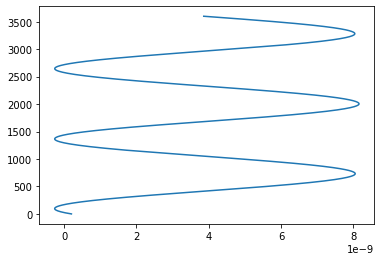

In [35]:
plt.plot(delta_s_comma_val, t)

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


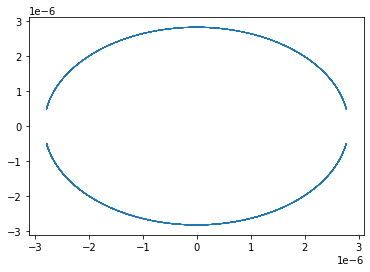

In [36]:
plt.scatter(x_vec, y_vec, delta_s_comma_val*10**-6)

Now as viewed from the earth

In [37]:
#check weather the Method is working in a timespan of 3600 minutes --> 60h
n = 3600

x_vec = np.zeros([n,1])
y_vec = np.zeros([n,1])
z_vec = np.zeros([n,1])
delta_t_comma_val = np.zeros([n,1])
t = np.zeros([n,1])

epoch = Epoch()
epoch.set(2020, 1, 2, 12, 0, 59)

X = np.array([[0],[0],[1]])/ au_j_r
M = np.array([[1,0,0],[0,1,0],[0,0,rho]])

Q_buffer = np.zeros([3,1])
    
for i in range(0, n):

    epoch += time_step

    a_squared = X.T @ M @ X

    #Position of the Earth, heliocentric ecliptical spherical coordinates system

    l_e, b_e, r_e = Earth.geometric_heliocentric_position(epoch)

    x_e = r_e * cos(b_e.rad()) * cos(l_e.rad()) 
    y_e = r_e * cos(b_e.rad()) * sin(l_e.rad()) 
    z_e = r_e * sin(b_e.rad())

    #Heliocentric position of Jupiter, ecliptical spherical coorinates system
    l_j, b_j, r_j = Jupiter.geometric_heliocentric_position(epoch)

    #convert from spherical to cartesian coordinates, always in the ecliptical system
    x_j = r_j * cos(b_j.rad()) * cos(l_j.rad()) 
    y_j = r_j * cos(b_j.rad()) * sin(l_j.rad()) 
    z_j = r_j * sin(b_j.rad())

    l_diff = l_e - l_j
    b_diff = b_e - b_j
    
    r_diff =np.linalg.norm(np.array([x_e - x_j, y_e - y_j, z_e - z_j]))
    
    x_diff = r_diff * cos(b_diff.rad()) * cos(l_diff.rad()) 
    y_diff = r_diff * cos(b_diff.rad()) * sin(l_diff.rad())
    z_diff = r_diff * sin(b_diff.rad()) 
    
    T = np.array([x_diff, y_diff, z_diff]).T

    S = np.array([r_j, 0, 0]).T

    position_matrix = (np.array(JupiterMoons.rectangular_positions(epoch, solar = True))).reshape(4, 3)
    #extract only one line-vector of a single satellite
    #taking Io into consideration, since there should be an eclipse on the given day

    Q = position_matrix[0, :].T

    Q_buffer = Q

    Q = np.array([-Q_buffer[2],Q_buffer[0] ,Q_buffer[1]])

    Q = Q / au_j_r

    Delta_t_comma = (T.T@M@T - a_squared)*(a_squared - S.T@M@Q)**2 + 2*(T.T@M@Q - a_squared)*(a_squared - S.T@M@Q)*(S.T@M@T - a_squared)+(Q.T@M@Q - a_squared)*(S.T@M@T - a_squared)**2 
    
    x_vec[i] = Q[0]
    y_vec[i] = Q[1]
    z_vec[i] = Q[2]
    
    delta_t_comma_val[i] = Delta_t_comma
    
    t[i] = i
    
    if(Delta_t_comma  < 0) :
        print(epoch.get_full_date())
        print(Delta_s_comma)

(2020, 1, 2, 13, 4, 58.979173600673676)
[[3.86400123e-09]]
(2020, 1, 2, 13, 5, 58.9788481593132)
[[3.86400123e-09]]
(2020, 1, 2, 13, 6, 58.97852271795273)
[[3.86400123e-09]]
(2020, 1, 2, 13, 7, 58.978197276592255)
[[3.86400123e-09]]
(2020, 1, 2, 13, 8, 58.97787183523178)
[[3.86400123e-09]]
(2020, 1, 2, 13, 9, 58.97754639387131)
[[3.86400123e-09]]
(2020, 1, 2, 13, 10, 58.977220952510834)
[[3.86400123e-09]]
(2020, 1, 2, 13, 11, 58.97689551115036)
[[3.86400123e-09]]
(2020, 1, 2, 13, 12, 58.97657006978989)
[[3.86400123e-09]]
(2020, 1, 2, 13, 13, 58.97624462842941)
[[3.86400123e-09]]
(2020, 1, 2, 13, 14, 58.97591918706894)
[[3.86400123e-09]]
(2020, 1, 2, 13, 15, 58.975593745708466)
[[3.86400123e-09]]
(2020, 1, 2, 13, 16, 58.97526830434799)
[[3.86400123e-09]]
(2020, 1, 2, 13, 17, 58.97494286298752)
[[3.86400123e-09]]
(2020, 1, 2, 13, 18, 58.974617421627045)
[[3.86400123e-09]]
(2020, 1, 2, 13, 19, 58.97429198026657)
[[3.86400123e-09]]
(2020, 1, 2, 13, 20, 58.9739665389061)
[[3.86400123e-09]]


(2020, 1, 3, 10, 20, 58.56391042470932)
[[3.86400123e-09]]
(2020, 1, 3, 10, 21, 58.563584983348846)
[[3.86400123e-09]]
(2020, 1, 3, 10, 22, 58.56325954198837)
[[3.86400123e-09]]
(2020, 1, 3, 10, 23, 58.5629341006279)
[[3.86400123e-09]]
(2020, 1, 3, 10, 24, 58.562608659267426)
[[3.86400123e-09]]
(2020, 1, 3, 10, 25, 58.56228321790695)
[[3.86400123e-09]]
(2020, 1, 3, 10, 26, 58.56195777654648)
[[3.86400123e-09]]
(2020, 1, 3, 10, 27, 58.561632335186005)
[[3.86400123e-09]]
(2020, 1, 3, 10, 28, 58.56130689382553)
[[3.86400123e-09]]
(2020, 1, 3, 10, 29, 58.56098145246506)
[[3.86400123e-09]]
(2020, 1, 3, 10, 30, 58.560656011104584)
[[3.86400123e-09]]
(2020, 1, 3, 10, 31, 58.56033056974411)
[[3.86400123e-09]]
(2020, 1, 3, 10, 32, 58.56000512838364)
[[3.86400123e-09]]
(2020, 1, 3, 10, 33, 58.55967968702316)
[[3.86400123e-09]]
(2020, 1, 3, 10, 34, 58.55935424566269)
[[3.86400123e-09]]
(2020, 1, 3, 10, 35, 58.559028804302216)
[[3.86400123e-09]]
(2020, 1, 3, 10, 36, 58.55870336294174)
[[3.86400123

(2020, 1, 4, 7, 45, 58.1457182765007)
[[3.86400123e-09]]
(2020, 1, 4, 7, 46, 58.14539283514023)
[[3.86400123e-09]]
(2020, 1, 4, 7, 47, 58.145067393779755)
[[3.86400123e-09]]
(2020, 1, 4, 7, 48, 58.14474195241928)
[[3.86400123e-09]]
(2020, 1, 4, 7, 49, 58.14441651105881)
[[3.86400123e-09]]
(2020, 1, 4, 7, 50, 58.144091069698334)
[[3.86400123e-09]]
(2020, 1, 4, 7, 51, 58.14376562833786)
[[3.86400123e-09]]
(2020, 1, 4, 7, 52, 58.14344018697739)
[[3.86400123e-09]]
(2020, 1, 4, 7, 53, 58.14311474561691)
[[3.86400123e-09]]
(2020, 1, 4, 7, 54, 58.14278930425644)
[[3.86400123e-09]]
(2020, 1, 4, 7, 55, 58.142463862895966)
[[3.86400123e-09]]
(2020, 1, 4, 7, 56, 58.14213842153549)
[[3.86400123e-09]]
(2020, 1, 4, 7, 57, 58.14181298017502)
[[3.86400123e-09]]
(2020, 1, 4, 7, 58, 58.141487538814545)
[[3.86400123e-09]]
(2020, 1, 4, 7, 59, 58.14116209745407)
[[3.86400123e-09]]
(2020, 1, 4, 8, 0, 58.1408366560936)
[[3.86400123e-09]]
(2020, 1, 4, 8, 1, 58.140511214733124)
[[3.86400123e-09]]
(2020, 1, 4, 

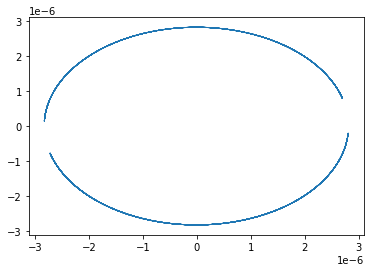

In [38]:
plt.scatter(x_vec, y_vec, delta_t_comma_val*10**-6)

Everything is looking plausible for the given test epochs, therefore now we we will mode on to the implentation of a method utilizing Chebyshev polynomials for predicting the ephemereids, as described by Tulliat

In [39]:
#set the interval to be an year long
T_I = 366 # days
#set the begin day to Jan 1.st of the same years
T_B = 0 #days
#set the sideral period to Io's
T_P = 1.7691374639 #days

stupid test to see if evrything still works, let's have an event on January second at 00:00, then just 1.72 days from then on

In [40]:
n_events, _ = divmod((T_I - 1),T_P)

print(str(n_events) + " events in the hypothetical year")

t = np.zeros([int(n_events),])

for i in range(0,int(n_events)):
    
    t[i] = 1 + T_P * i + 0.25*sin(np.deg2rad(i*360/206))
    
print(t)
    

206.0 events in the hypothetical year
[  1.           2.77676151   4.55351592   6.33025616   8.10697514
   9.88366583  11.66032118  13.43693422  15.21349797  16.99000555
  18.76645008  20.54282477  22.3191229   24.09533779  25.87146287
  27.64749163  29.42341767  31.19923467  32.97493641  34.7505168
  36.52596983  38.30128963  40.07647046  41.85150668  43.62639281
  45.40112351  47.17569357  48.95009793  50.72433171  52.49839015
  54.27226868  56.04596289  57.81946854  59.59278156  61.36589808
  63.1388144   64.91152698  66.68403252  68.45632788  70.22841011
  72.00027649  73.77192446  75.54335171  77.31455609  79.08553568
  80.85628877  82.62681387  84.39710966  86.16717509  87.93700928
  89.70661159  91.47598159  93.24511905  95.01402398  96.7826966
  98.55113734 100.31934684 102.08732597 103.85507581 105.62259764
 107.38989297 109.15696352 110.92381121 112.69043816 114.45684671
 116.2230394  117.98901897 119.75478836 121.5203507  123.28570932
 125.05086773 126.81582963 128.58059891 

In [41]:
N = np.floor((t - T_B)/ T_P)

print(N)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [42]:
tau = t - (T_B + N*T_P)
print(np.shape(t))
print(np.shape(tau))

print(tau)

(206,)
(206,)
[1.         1.00762404 1.01524099 1.02284377 1.03042529 1.03797851
 1.0454964  1.05297197 1.06039826 1.06776837 1.07507544 1.08231267
 1.08947333 1.09655076 1.10353837 1.11042967 1.11721825 1.12389778
 1.13046206 1.13690498 1.14322055 1.14940289 1.15544625 1.16134501
 1.16709368 1.17268691 1.17811951 1.18338641 1.18848272 1.19340369
 1.19814476 1.20270151 1.20706969 1.21124526 1.21522431 1.21900316
 1.22257828 1.22594636 1.22910425 1.23204902 1.23477793 1.23728844
 1.23957822 1.24164514 1.24348727 1.2451029  1.24649053 1.24764886
 1.24857682 1.24927355 1.2497384  1.24997093 1.24997093 1.2497384
 1.24927355 1.24857682 1.24764886 1.24649053 1.2451029  1.24348727
 1.24164514 1.23957822 1.23728844 1.23477793 1.23204902 1.22910425
 1.22594636 1.22257828 1.21900316 1.21522431 1.21124526 1.20706969
 1.20270151 1.19814476 1.19340369 1.18848272 1.18338641 1.17811951
 1.17268691 1.16709368 1.16134501 1.15544625 1.14940289 1.14322055
 1.13690498 1.13046206 1.12389778 1.11721825 1.11

In [43]:
chebyshev_coeff = np.polynomial.chebyshev.chebfit(t, tau, 14)

In [44]:
print(chebyshev_coeff)

[ 9.95708970e-01  4.29080310e-03  3.18611878e-07 -5.25916310e-08
  5.72386864e-13  1.57342512e-13  2.09324909e-16 -1.29689033e-18
  3.59883606e-21 -8.52685862e-24  1.33815150e-26 -1.21979956e-29
  5.83445246e-33 -1.04443875e-36 -6.79843015e-41]


In [45]:
x = np.linspace(0, 366, 366)

y_c = np.polynomial.chebyshev.chebval(x, chebyshev_coeff)

In [46]:
print(y_c)

[0.99570865 1.0000118  1.00431495 1.00861684 1.0129162  1.01721175
 1.02150223 1.02578637 1.0300629  1.03433056 1.0385881  1.04283424
 1.04706775 1.05128737 1.05549185 1.05967995 1.06385044 1.06800208
 1.07213365 1.07624393 1.08033169 1.08439574 1.08843487 1.09244789
 1.09643361 1.10039084 1.10431843 1.10821521 1.11208001 1.11591171
 1.11970915 1.12347123 1.12719681 1.13088481 1.13453411 1.13814364
 1.14171233 1.14523912 1.14872295 1.15216279 1.15555763 1.15890644
 1.16220823 1.16546202 1.16866683 1.17182171 1.17492573 1.17797794
 1.18097745 1.18392334 1.18681475 1.18965081 1.19243066 1.19515347
 1.19781843 1.20042473 1.20297159 1.20545825 1.20788396 1.21024798
 1.2125496  1.21478813 1.2169629  1.21907323 1.2211185  1.22309808
 1.22501138 1.2268578  1.2286368  1.23034781 1.23199034 1.23356386
 1.2350679  1.23650199 1.2378657  1.23915861 1.2403803  1.24153041
 1.24260858 1.24361447 1.24454776 1.24540816 1.2461954  1.24690923
 1.24754942 1.24811575 1.24860806 1.24902616 1.24936993 1.2496

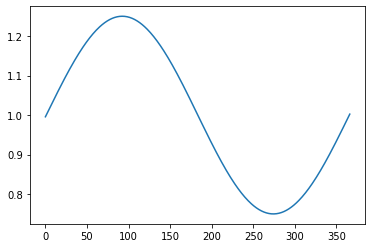

In [47]:
plt.plot(x, y_c)

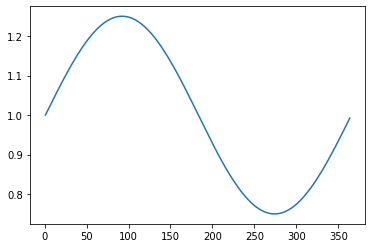

In [48]:
plt.plot(t, tau)

Chebyshev polinomial interpolation seems to be working, let's now test it out on real data, at first only for a month

In [49]:
epoch_start = Epoch()
epoch_start.set(2020, 1, 1, 0)

epoch_stop = Epoch()
epoch_stop.set(2020, 2, 1, 0)

calc_time_step = 60 * 120 * 1.157401129603386e-05

calc = Calculation(epoch_start, epoch_stop, calc_time_step, 0)

for tmng in calc.all_timings_sorted:
    print(tmng.epoch.get_full_date(), tmng.row, tmng.phenomenom.phenomenom_type, tmng.appereance_type,
          tmng.phenomenom.shadow_type)

Coordinate Calculation finished for:  Coordinate Calculation finished for: 2458861.1666033864   - 2458857.333290845   - Coordinate Calculation finished for:  2458865.083248809 2458865.083248809
2458861.1666033864 
 -  2458868.91656135Coordinate Calculation finished for: 
 2458872.833206773Coordinate Calculation finished for:    - Coordinate Calculation finished for: 2458849.5   -   2458853.41664542262458853.4166454226
2458876.666519314 
 - Coordinate Calculation finished for:   2458857.3332908452458876.666519314
Coordinate Calculation finished for:   2458868.91656135  -  -   2458872.8332067732458880.5831647366

Got rough timings
Exact timings for Satellite  4 , phenomenom:  0 Exact timings for Satellite   calculated
4 , phenomenom:  1  calculated
Exact timings for Satellite  4 , phenomenom:  Exact timings for Satellite 2   calculated4
 , phenomenom:  3  calculated
Exact timings for Satellite  3Exact timings for Satellite   , phenomenom: 3  2, phenomenom:    calculated3
  calculated
Exa

In [50]:
eclipse_signal = np.zeros([1 , 60*60*24*31])

base_epoch = Epoch()
base_epoch.set(2020, 1, 1, 0)

print(np.shape(eclipse_signal))

event_ctr = 0;

for tmng in calc.all_timings_sorted:


    if((tmng.row == 0) & (tmng.phenomenom.phenomenom_type == 'EC') & (tmng.appereance_type == 'start') \
       & (tmng.phenomenom.shadow_type == 'EXT')):

        #print(tmng.epoch.get_full_date(), tmng.row, tmng.phenomenom.phenomenom_type, tmng.appereance_type,
              #tmng.phenomenom.shadow_type)
        
        time_bin = np.round((tmng.epoch.jde()-base_epoch.jde()) * 1/s_jd)
        
        #print(time_bin.astype(int))
        
        eclipse_signal[0,time_bin.astype(int)] = 1
        
        event_ctr += 1

eclipse_timing = np.zeros([1,event_ctr])
        
event_ctr = 0

for i in range(0,60*60*24*31):

    if(eclipse_signal[0,i] != 0):
        print("Value at : " + str(i*s_jd) + " : " + str(eclipse_signal[0,i]))     
        
        eclipse_timing[0,event_ctr] = i*s_jd
        
        event_ctr += 1
        
        
eclipse_timing = eclipse_timing[eclipse_timing != 0]
        
print(eclipse_timing)

(1, 2678400)
Value at : 1.5264037577435374 : 1.0
Value at : 3.296289991121739 : 1.0
Value at : 5.066129928454757 : 1.0
Value at : 6.8360277358442545 : 1.0
Value at : 8.60584452515468 : 1.0
Value at : 10.37570761051029 : 1.0
Value at : 12.145535973832011 : 1.0
Value at : 13.915410633198917 : 1.0
Value at : 15.68520427448675 : 1.0
Value at : 17.455055785831064 : 1.0
Value at : 19.224849427118897 : 1.0
Value at : 20.99470093846321 : 1.0
Value at : 22.76448300573975 : 1.0
Value at : 24.53431136906147 : 1.0
Value at : 26.304093436338007 : 1.0
Value at : 28.07392179965973 : 1.0
Value at : 29.84369229292497 : 1.0
[ 1.52640376  3.29628999  5.06612993  6.83602774  8.60584453 10.37570761
 12.14553597 13.91541063 15.68520427 17.45505579 19.22484943 20.99470094
 22.76448301 24.53431137 26.30409344 28.0739218  29.84369229]


In [115]:
#set the interval to be a month long
T_I = 31 # days
#set the begin day to Jan 1.st of the same years
T_B = 0 #days
#set the sideral period to Io's
T_P = 1.7698605 #days

In [116]:
n_events, _ = divmod((T_I - T_B),T_P)

print(str(n_events) + " events in the month of Jan 2020")

t = eclipse_timing
    
print(t)

17.0 events in the month of Jan 2020
[ 1.52640376  3.29628999  5.06612993  6.83602774  8.60584453 10.37570761
 12.14553597 13.91541063 15.68520427 17.45505579 19.22484943 20.99470094
 22.76448301 24.53431137 26.30409344 28.0739218  29.84369229]


In [117]:
N = np.floor((t - T_B)/ T_P)

print(N)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]


In [118]:
tau = t - (T_B + N*T_P)

print(tau)

[1.52640376 1.52642949 1.52640893 1.52644624 1.52640253 1.52640511
 1.52637297 1.52638713 1.52632027 1.52631129 1.52624443 1.52623544
 1.52615701 1.52612487 1.52604644 1.5260143  1.52592429]


In [119]:
chebyshev_coeff = np.polynomial.chebyshev.chebfit(t, tau, 14)
print(chebyshev_coeff)

[ 1.47530402e+00  6.68068031e-02 -2.24533507e-02  4.48691815e-03
 -5.83076033e-04  5.21008720e-05 -3.31451649e-06  1.53219812e-07
 -5.19431104e-09  1.29003877e-10 -2.31816423e-12  2.93122297e-14
 -2.47172362e-16  1.24695881e-18 -2.84523658e-21]


In [120]:
x = np.linspace(0, 31, 31)

y_c = np.polynomial.chebyshev.chebval(x, chebyshev_coeff)

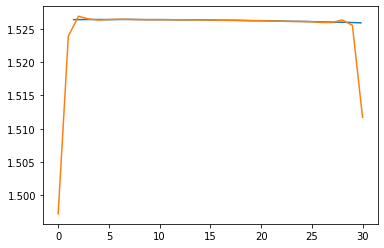

In [121]:
plt.plot(t, tau, y_c)

Now let's test it on Jan the 15.th

In [122]:
t_0 = 15

N_0 = np.floor((t_0 - T_B)/ T_P)

Theta_0 = arccos(2*(t_0-T_B)/T_I -1)

print(N_0)
print(np.rad2deg(Theta_0))

8.0
91.84857164522856


In [123]:
n = np.linspace(0, 14, 15)

tau_0 = np.sum(chebyshev_coeff * cos(Theta_0*n))

print(tau_0)

1.4954058825706307


In [124]:
t_1 = T_B + N_0*T_P + tau_0

print(t_1)

15.65428988257063
